## Polygon AutoEncoder

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from Prepare_dataset import prepare_dataset, prepare_dataset_fixedsize

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, max_seq_len):
        super().__init__()

        pe = torch.zeros(max_seq_len, emb_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * -(math.log(10000.0) / emb_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [12]:
class Pae(nn.Module):
    def __init__(self, emb_dim, num_heads, ffn_dim, num_layers, dropout, max_seq_len):
        super().__init__()

        self.cls_emb = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.enc_layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model=emb_dim,
                                                                    nhead=num_heads,
                                                                    dim_feedforward=ffn_dim,
                                                                    dropout=dropout,
                                                                    batch_first=True) for _ in range(num_layers)])
        self.dec_layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model=emb_dim,
                                                                    nhead=num_heads,
                                                                    dim_feedforward=ffn_dim,
                                                                    dropout=dropout,
                                                                    batch_first=True) for _ in range(num_layers)])
        # self.pos_emb = PositionalEncoding(emb_dim, max_seq_len)
        self.pos_emb = nn.Parameter(torch.randn(1, 1 + max_seq_len, emb_dim))

    def forward(self, x, mask=None):
        class_emb = self.cls_emb.repeat(x.size(0), 1, 1)
        x = torch.cat([class_emb, x], dim=1)
        # x = self.pos_emb(x)
        x = x + self.pos_emb

        if mask is not None:
            cls_mask = torch.zeros((x.size(0), 1), dtype=torch.bool)
            mask = torch.cat((cls_mask, mask), dim=1)

        hidden = x
        for enc_layer in self.enc_layers:
            hidden = enc_layer(hidden, src_key_padding_mask=mask)
        
        y = hidden
        for dec_layer in self.dec_layers:
            y = dec_layer(y, src_key_padding_mask=mask)
        
        loss = (y - x) ** 2
        loss = loss.mean(dim=-1)
        if mask is not None:
            loss = (loss * mask).sum() / mask.sum()
        else:
            loss = loss.sum() / x.size(0)
        return hidden, y, loss

In [5]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

In [6]:
geom_train, geom_test, label_train, label_test = prepare_dataset_fixedsize()

In [8]:
train_tokens = torch.tensor(geom_train, dtype=torch.float32)
test_tokens = torch.tensor(geom_test, dtype=torch.float32)
train_labels= torch.tensor(label_train, dtype=torch.long)
test_labels = torch.tensor(label_test, dtype=torch.long)

In [9]:
train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(test_tokens, test_labels), batch_size=32)

In [14]:
pae = Pae(emb_dim=5, num_heads=1, num_layers=3, max_seq_len=64, ffn_dim=64, dropout=0.1)

if USE_GPU:
    pae = pae.to(device)

optimizer = optim.Adam(pae.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9)

num_epochs = 50

def train(model, loader):
    model.train()
    train_loss = 0.0
    # correct = 0
    # total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        hidden, outputs, loss = pae(batch_x)
        loss.backward()
        optimizer.step()
        train_loss += loss
        # _, predicted = torch.max(outputs, 1)
        # total += batch_y.size(0)
        # correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    # train_acc = correct / total
    return train_loss

def evaluate(model, loader):
    model.eval()
    eval_loss = 0.0
    # correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            if USE_GPU:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            hidden, outputs, loss = pae(batch_x)
            eval_loss += loss
            # _, predicted = torch.max(outputs, 1)
            # total += batch_y.size(0)
            # correct += (predicted == batch_y).sum().item()
    eval_loss /= len(loader)
    # eval_acc = correct / total
    return eval_loss

for epoch in range(num_epochs):
    train_loss = train(pae, train_loader)
    val_loss = evaluate(pae, val_loader)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")


# # Test
# test_loss = evaluate(pae, test_loader)
# print(f"Test Loss: {test_loss}")

Epoch: 1, Train Loss: 24.309152603149414, Val Loss: 16.003620147705078
Epoch: 2, Train Loss: 15.181729316711426, Val Loss: 11.271306991577148
Epoch: 3, Train Loss: 11.05633544921875, Val Loss: 8.333662986755371
Epoch: 4, Train Loss: 8.287487030029297, Val Loss: 6.246378421783447
Epoch: 5, Train Loss: 6.282419204711914, Val Loss: 4.721860408782959
Epoch: 6, Train Loss: 4.800756931304932, Val Loss: 3.6148762702941895
Epoch: 7, Train Loss: 3.7181689739227295, Val Loss: 2.81327486038208
Epoch: 8, Train Loss: 2.925593614578247, Val Loss: 2.223863363265991
Epoch: 9, Train Loss: 2.3494255542755127, Val Loss: 1.8011291027069092
Epoch: 10, Train Loss: 1.9316542148590088, Val Loss: 1.490031123161316
Epoch: 11, Train Loss: 1.6265101432800293, Val Loss: 1.267600655555725
Epoch: 12, Train Loss: 1.4104032516479492, Val Loss: 1.0997432470321655
Epoch: 13, Train Loss: 1.2397035360336304, Val Loss: 0.9703136682510376
Epoch: 14, Train Loss: 1.109947919845581, Val Loss: 0.860922634601593
Epoch: 15, Train

In [15]:
hidden, outputs, loss = pae(test_tokens)
# print(train_tokens[0])
# print(outputs[0])
hidden = hidden.view(test_tokens.size(0), -1)
hidden = hidden.detach().numpy()

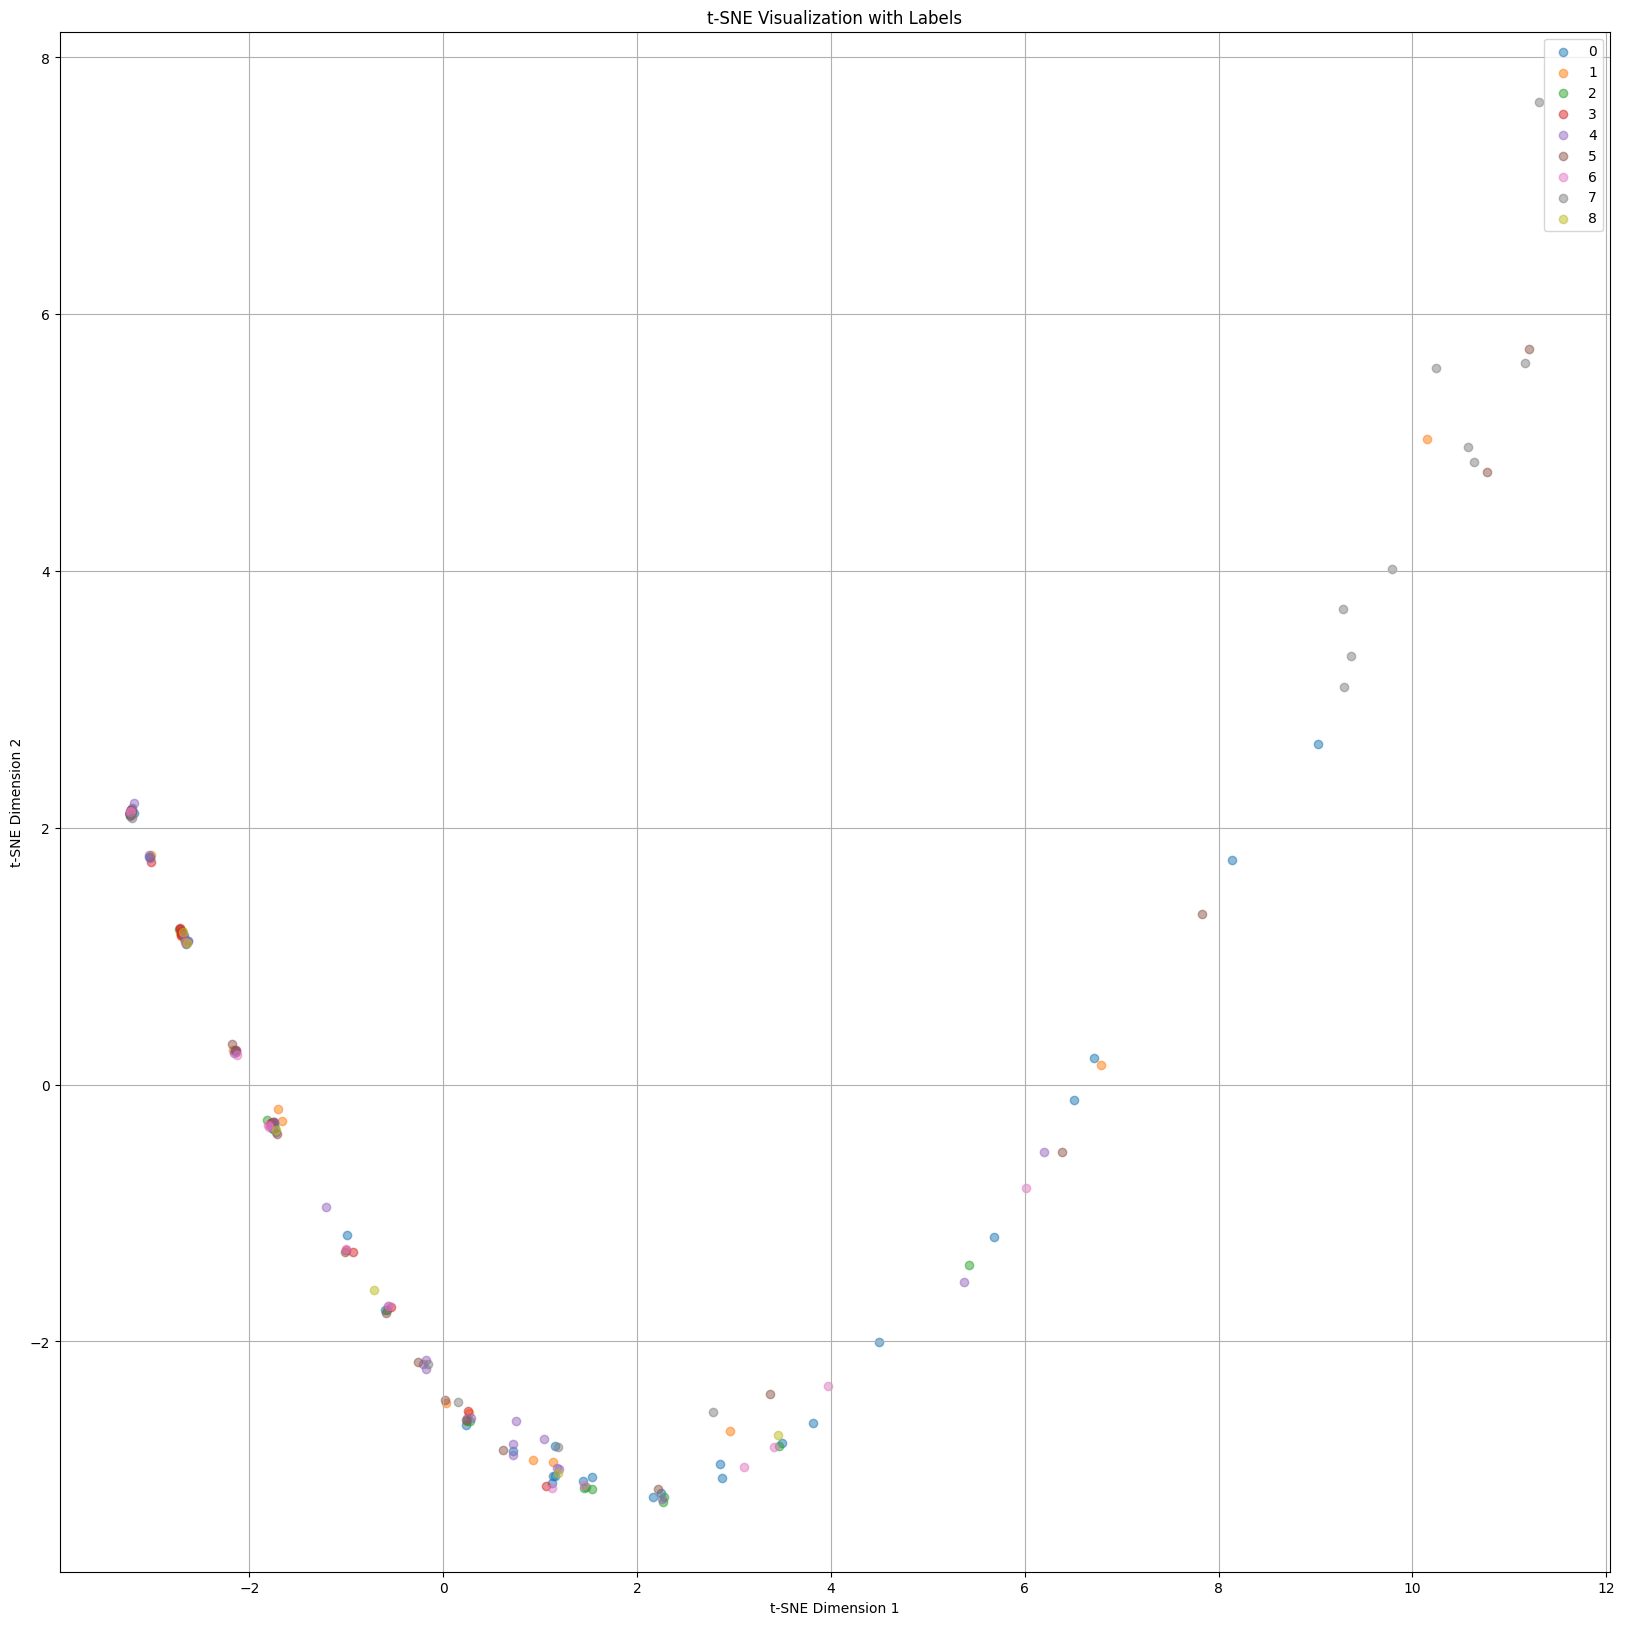

In [17]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


# tsne = TSNE(n_components=2, random_state=0)
# projections = tsne.fit_transform(hidden)

pca = PCA(n_components=2)
projections = pca.fit_transform(hidden)

# fig = px.scatter(
#     x=projections[:, 0],
#     y=projections[:, 1],
#     color=test_labels
# )

# fig.show()


plt.figure(figsize=(20, 20))

# Plot each class separately
for label in np.unique(test_labels):
    indices = test_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
with torch.no_grad():
    train_hidden = pae(train_tokens)[0].view(train_tokens.size(0), -1)
    val_hidden = pae(test_tokens)[0].view(test_tokens.size(0), -1)

# train_hidden = train_tokens.view(train_tokens.size(0), -1)
# val_hidden = test_tokens.view(test_tokens.size(0), -1)

train_loader = DataLoader(TensorDataset(train_hidden, train_labels), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(val_hidden, test_labels))

In [41]:
test_labels.tolist().count(8)

6

In [42]:
classifier = Classifier(train_hidden.size(1), 128, 9, 0.5)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(pot.parameters(), lr=0.004)
optimizer = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

num_epochs = 50

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, loader):
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            if USE_GPU:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            eval_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    eval_loss /= len(val_loader)
    eval_acc = correct / total
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, train_loader)
    val_loss, val_acc = evaluate(classifier, val_loader)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 2.0918959474563597, Train Acc 0.16125, Val Loss: 2.064854945540428, Val Acc: 0.225
Epoch: 2, Train Loss: 2.018516182899475, Train Acc 0.185, Val Loss: 2.0452109882235527, Val Acc: 0.175
Epoch: 3, Train Loss: 1.9963350915908813, Train Acc 0.2075, Val Loss: 2.0449572518467902, Val Acc: 0.17
Epoch: 4, Train Loss: 1.983167757987976, Train Acc 0.20375, Val Loss: 2.0008737257122995, Val Acc: 0.25
Epoch: 5, Train Loss: 1.9714325809478759, Train Acc 0.21875, Val Loss: 2.06217093706131, Val Acc: 0.16
Epoch: 6, Train Loss: 1.9635336256027223, Train Acc 0.22, Val Loss: 1.9969696396589278, Val Acc: 0.25
Epoch: 7, Train Loss: 1.9644097232818603, Train Acc 0.2325, Val Loss: 2.0332457801699637, Val Acc: 0.18
Epoch: 8, Train Loss: 1.9449423170089721, Train Acc 0.24125, Val Loss: 2.0062933015823363, Val Acc: 0.215
Epoch: 9, Train Loss: 1.9413128042221068, Train Acc 0.23625, Val Loss: 2.0060559797286985, Val Acc: 0.245
Epoch: 10, Train Loss: 1.944131507873535, Train Acc 0.225, Val 